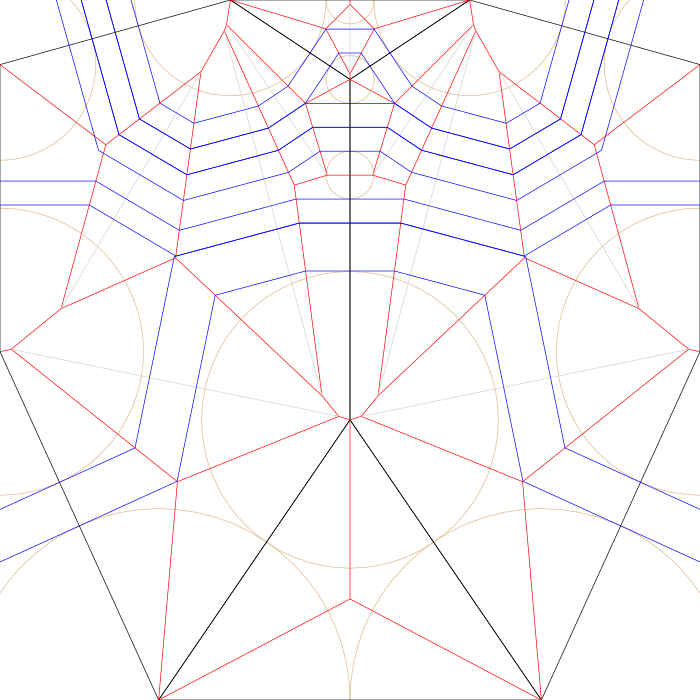

In [8]:
import networkx as nx
import numpy as np
from itertools import count, combinations
from shapely.geometry import Polygon, Point, MultiPoint, LineString, MultiLineString
from shapely.geometry.polygon import orient
from shapely.ops import split, linemerge, nearest_points, polygonize
from shapely.affinity import rotate, translate, scale
from shapely import wkt
from sample_trees import *
from render_pattern import *

STEP = 10
EPSILON = 3
ROUND_PRECISION = 6

# tree properties
def nodes_with_attribute(tree,att): return [n for n,d in tree.nodes(data=True) if d==att]
def interior_nodes(tree): return nodes_with_attribute(tree,{})
def tree_distance(n1,n2,d): return d[n1][n2]
def get_edge_weight (tree,node): return[(c["weight"]) for (a, b, c) in tree.edges(node,data=True)][0]
def path_to_leaf(node,tree,path = []):
    for n in tree.neighbors(node):
        if tree.degree(n) == 1: return path+[n] #found a leaf!
    path_to_leaf(n,tree,path+[n]) 
    
# affine transforms
def line_move_to (line,point): return translate(line, point.x- start_point(line).x,point.y - start_point(line).y)
def line_orthogonal(line): return rotate(line,90,origin=start_point(line))
def line_stretch(line,size): return scale(line,xfact=size/line.length,yfact=size/line.length,origin=start_point(line))

# geometric calculations
def are_colinear(p1,p2,p3): return p2.intersects(line_from_points(p1,p3)) and not (p1.equals(p2) or p1.equals(p3) or p2.equals(p3))
def find_colinear_points(points): return [points[i-1] for i in range(len(points)) if are_colinear(points[i-2],points[i-1],points[i])]
def azimuth(point1, point2): return np.degrees(np.arctan2(point2.x - point1.x, point2.y - point1.y))
def parallel_line(line,offset,side): return line.parallel_offset(offset,side,join_style=2)
def buffer_line_symmetric(line_segments,offset): return [parallel_line(line_segments,offset,'left'),parallel_line(line_segments,offset,'right')]
def tiny_segment(line,p): return line_from_points(Point(coords(line.intersection(p.buffer(0.1)))),p)
def connect_points(points): return [line_from_points(points.centroid,p) for p in get_vertices(points)]
def angular_bisectors(polygon): return [line_stretch(line_from_points(v,vertex_at_index(i,polygon.buffer(-1))),polygon.length) for i,v in enumerate(get_vertices(polygon))]
def mirror_line(source_line,through_line,at_point):
    angle = azimuth(*get_vertices(source_line)) - azimuth(*get_vertices(tiny_segment(through_line,at_point)))
    return line_move_to(rotate(source_line,180+2*angle,origin=at_point),at_point)

def first_intersection (line,other_lines,ref = float('inf'),intersection_point = None,intersecting_line = None):
    for other_line in other_lines:
        intersection = line.intersection(other_line) 
        if not intersection.is_empty:
            for point in [intersection]:
                distance = start_point(line).distance(point)
                if EPSILON < distance < ref: 
                    intersection_point,intersecting_line,ref = point,other_line,distance
    return intersection_point, intersecting_line

# shapely wrappers
def convex_polygon(points): return Polygon(points).convex_hull
def nearest_vertex(point,polygon): return nearest_points(point,polygon)[1]
def start_point(line): return get_vertices(line)[0]
def end_point(line): return get_vertices(line)[-1]
def line_from_points(p1,p2): return LineString([p1,p2])
def approx(geom): return wkt.loads(wkt.dumps(geom,rounding_precision=ROUND_PRECISION))
def line_on_polygon(line,polygon): return line.relate(polygon) == 'F1FF0F212'
def line_not_in_multiline(line,lines): return line.relate(lines) == 'FF100F102'
def get_vertices(geom): return MultiPoint(coords(geom)[:-1]) if type(geom) == Polygon else MultiPoint(coords(geom))
def get_nodes(geom,node_map): return node_map[coords(geom)] if type(geom) == Point else [node_map[g] for g in coords(geom)] 
def coords (geom): 
    if type(geom) == Point: return geom.coords[0]
    if type(geom) == LineString: return geom.coords[:]
    if type(geom) == Polygon: return geom.exterior.coords[:]
    if type(geom) == list or tuple: return [coords(g) for g in geom]
    
# node <-> geometry maps    
def vertex_from_node(node,node_map): return Point(next((point for point, i in node_map.items() if i == node), None))
def vertices_in_origin(vertices,node_map_origin,node_map): return [vertex_from_node(get_nodes(vertex,node_map),node_map_origin) for vertex in vertices]
def line_in_origin(line,node_map_origin,node_map): return line_from_points(*vertices_in_origin(get_vertices(line),node_map_origin,node_map))
def line_from_nodes(node1,node2,node_map): return line_from_points(vertex_from_node(node1,node_map),vertex_from_node(node2,node_map))

# vertices in polygons
def index_from_vertex(vertex,polygon): return coords(polygon).index(coords(vertex))
def vertex_at_index(index,polygon): return get_vertices(polygon)[index]
def edge_from_indices(index1,index2,polygon): return line_from_points(coords(polygon)[index1],coords(polygon)[index2])
def vertex_in_polygon(vertex,polygons): return [p for p in polygons if coords(vertex) in coords(p)]
def adjacent_edges(vertex,polygon):
    index = index_from_vertex(vertex,polygon)
    return [edge_from_indices(index,index+1,polygon), edge_from_indices(index-1,index,polygon)]

def query_matrix(m,val):
    res = np.where(m==val)
    return list(zip(res[0],res[1]))

def extend_lines(lines,extension):
    for i,line in enumerate(lines):
        if approx(extension).touches(approx(line)):
            merge = linemerge(MultiLineString([extension,line]))
            if type(merge) == LineString: lines[i] = merge
            return lines
    lines += [extension]
    return lines

def is_split_event(c,poly,node_map,node_map_origin,d,h): return lang_distances(*get_vertices(c),node_map,node_map_origin,poly,h)-tree_distance(*get_nodes(c,node_map),d)< EPSILON
def lang_distances(vertex1,vertex2,node_map,node_map_origin,poly,h): 
    return project_on_origin(node_map,node_map_origin,vertex1,poly,h) + vertex1.distance(vertex2) + project_on_origin(node_map,node_map_origin,vertex2,poly,h) 
def project_on_origin(node_map,node_map_origin,vertex,polygon,h):
    edge = [edge_from_indices(i,i+1,polygon) for i,p in enumerate(get_vertices(polygon)) if p.almost_equals(vertex,ROUND_PRECISION)]
    d = line_in_origin(*edge,node_map_origin,node_map).project(vertex)
    return d if d>0 else h/2

def contract_triangle(triangle):
    # find the angular bisectors of the triangle
    bisectors = angular_bisectors(triangle)
    
    # find intersection point between any of the bisectors
    intersection = bisectors[0].intersection(bisectors[1])
    
    #return the angular bisectors until they intersect
    return [line_from_points(v,intersection) for v in get_vertices(triangle)]   

def shrink_polygon(polygon,sweep_length,node_map,distances,active,node_map_origin,h_last=0,creases=[],guides=[],h=0):    
   # shrink the polygon
    polygon_prime = polygon.buffer(-sweep_length) 
    h+=sweep_length
    
    # look for contraction events
    if polygon_prime.is_empty: 
        creases += connect_points(polygon)
        return creases, guides 
    
    # look for split events
    if len(coords(polygon)) > 4:          # ignore triangles as no split event can happen here
        # find the active paths
        for nodes in query_matrix(active,1):
            cut_path = line_from_nodes(nodes[0],nodes[1],node_map)
            if is_split_event(cut_path,
                              polygon,
                              node_map,
                              node_map_origin,
                              distances,h_last): 
                guides += [cut_path]
                [shrink_polygon(split,
                                sweep_length,
                                node_map.copy(),
                                distances,
                                get_active_paths(split,node_map, distances),
                                node_map,h,
                                creases,guides,h) for split in split(polygon, cut_path)]
                return creases,guides
    
    # contract triangles right away
    else:     
        creases += contract_triangle(polygon)
        return creases,guides

    #insert colinear vertices from polygon into polygon_prime
    polygon_prime = insert_colinear_vertices(polygon,polygon_prime)

    # generate creases        
    for i,p in enumerate(coords(polygon)[1:]):
        p_prime = coords(polygon_prime)[i+1]
        
        #extend the crease lines with a line from p to p_prime
        extend_lines(creases,line_from_points(p,p_prime))
        
        #update the node map
        node_map[p_prime] = node_map.pop(p) 

    # recursively call the shrinking with the new polygon
    return shrink_polygon(polygon_prime,
                          sweep_length,
                          node_map,
                          distances,
                          active,
                          node_map_origin,
                          h_last,
                          creases,
                          guides,h)

def insert_colinear_vertices(source,target):
    # get the coordinates of target vertices
    vertices = coords(target)
    
    # find colinear points in the source vertices
    colinear = find_colinear_points(get_vertices(source))    
    
    # copy over the colinear points from source to the target vertices
    for col_point in colinear:
        vertex = nearest_vertex(col_point,target) 
        vertices.insert(index_from_vertex(col_point,source),vertex)
        
        # if the vertex is the 0th vertex there is a copy at the end of the list which has to be removed
        if (vertices[0] == vertex): del vertices[-1]
    
    # return a modified polygon with new vertices
    return Polygon(vertices)

def get_active_paths(polygon,node_map,dist):
    # initiate a matrix of for all combinations of nodes
    paths = np.zeros((len(node_map),len(node_map)))
    
    # traverse all combinations of vertices in polygon
    for p1,p2 in combinations(get_vertices(polygon),2):
        
        # get the corresponding nodes
        node1, node2 = get_nodes(p1,node_map),get_nodes(p2,node_map)
        
        # set the path between the ndoes to 1 if the distance is bigger than epsilon, otherwise -1
        paths[node1][node2] = 1 if p1.distance(p2)-tree_distance(node1,node2,dist) > EPSILON else -1
    
    return paths

def propagate_line(line,creases,segments):
    # find the first intersection between line and creases
    intersection_point, intersecting_crease = first_intersection(line,creases)
    
    # if no intersection point is found, stop recursive call
    if intersection_point == None: return extend_lines(segments,line)[-1] 
    
    # add a line segment until the first intersection to segments
    segments = extend_lines(segments,line_from_points(start_point(line),intersection_point))

    # recursively call the propagate function where line is mirrored through intersecting_crease
    return propagate_line(
                mirror_line(
                line,
                intersecting_crease,
                intersection_point
                ), creases, segments)



def get_lang_polys(points,node_map,active):
    # add all active edges to the polys
    edges = [line_from_nodes(nodes[0],nodes[1],node_map) for nodes in query_matrix(active,-1)] 
    
    # find inactive edges
    inactive = [line_from_nodes(nodes[0],nodes[1],node_map) for nodes in query_matrix(active,1)] 
    
    #add inactive edges to polygon if they are on the outside
    edges += [line for line in inactive if line_on_polygon(line,convex_polygon(points)) and line_not_in_multiline(line,MultiLineString(polys))] 
    
    #create polygons from the edges, if polygonize fails, just create a single conex polygon from all points
    return list(polygonize(edges)) if len(list(polygonize(edges))) >0 else [convex_polygon(points)]


def generate_rivers(polygons,tree,node_map,dist,cr,rivers=[],visited=[]):
    for node in interior_nodes(tree):
        path = path_to_leaf(node,tree)
        leaf = vertex_from_node(path[-1],node_map)
        polygon = vertex_in_polygon(leaf,polygons)[0]
        edges = adjacent_edges(leaf,polygon)
        for edge in edges:
            nodes_on_edge = nx.shortest_path(tree,*get_nodes(edge,node_map))
            if node in nodes_on_edge and len(nodes_on_edge)>3: 
                    e = line_from_points(leaf,end_point(edge)) if start_point(edge) == leaf else line_from_points(leaf,start_point(edge))
                    other_node = nodes_on_edge[nodes_on_edge.index(node)-1]
                    other_node = other_node if other_node in interior_nodes(tree) else nodes_on_edge[nodes_on_edge.index(node)+1]
                    if not ((node,other_node) in visited):
                        width = dist[other_node][node]/2
                        start = e.interpolate(get_edge_weight(tree,path[-1]) + width)
                        line = line_move_to(line_orthogonal(line_stretch(e,polygon.length)),start)
                        rivers += buffer_line_symmetric(propagate_line(line,cr,[]),width)
                        rivers += buffer_line_symmetric(propagate_line(rotate(line,180,origin=start),cr,[]),width)
                        visited.extend([(other_node,node),(node,other_node)])
    return rivers


# load a tree, corresponding points and a map between points and nodes
points,node_map,tree,tree_distances = beetleTree()#beetleTree()#threeNodesTree()#lizardTree()#antennaBeetleTree()

# find active paths from the points
active_paths = get_active_paths(Polygon(points),node_map,tree_distances)

# create polygons from active paths or paths on the edge of the paper
polys = get_lang_polys(points,node_map,active_paths)

# shrink the polygons to find their creases
for polygon in polys:
    active_paths = get_active_paths(polygon,node_map,tree_distances)
    crease_lines,guide_lines = shrink_polygon(polygon,STEP,node_map.copy(),tree_distances,active_paths,node_map)

# add rivers to the crease pattern
rivers = generate_rivers(polys,tree,node_map,tree_distances,crease_lines)

# place circles for visual guidance
circles = [point.buffer(get_edge_weight(tree,get_nodes(point,node_map))) for point in points]

# render the result to export.svg
render(points,circles,crease_lines,guide_lines,polys,rivers)




In [7]:
P = Polygon([[0, 0], [1, 0], [1, 1], [0, 0]])
pts = [Point(0,0), Point(1,0),Point(1,1),Point(0,0)]
L = LineString(pts)
print(coords(pts[1]))

(1.0, 0.0)


In [27]:
for p1,p2 in combinations(range(10),2):
    print (p1,p2)
    
print("=====")
for p1 in range(10):
    for p2 in range(10):
        if p1<p2:
            print(p1,p2)

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
=====
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
